# Sentiment-Based Product Recommendation System

## Ebuss E-Commerce Platform

---

### Project Overview

I'm working as an ML Engineer at **Ebuss**, an e-commerce company that sells a wide range of products - electronics, household items, books, personal care, and more. The company has been growing steadily, but we're competing with giants like Amazon and Flipkart who have sophisticated recommendation engines.

**The Problem:**  
Our current recommendation system is pretty basic. It either shows "trending products" (what's selling the most) or "customers also bought" (simple co-purchase patterns). The issue? A product might be selling well but have terrible reviews. We've been recommending products that users end up returning or complaining about.

**My Solution:**  
Build a **hybrid recommendation system** that doesn't just look at purchase patterns, but also understands customer sentiment. The idea is straightforward:

1. **Collaborative Filtering** - Find users with similar tastes and see what they liked
2. **Sentiment Analysis** - Train an ML model to understand if reviews are positive or negative
3. **Combine Both** - Only recommend products that similar users liked AND have genuinely positive reviews

**What This System Does:**
- Takes a username as input
- Finds 20 products the user might like (using User-Based Collaborative Filtering)
- Analyzes all reviews for those products using our sentiment model
- Returns the top 5 products with the highest positive sentiment ratio

**Dataset:** ~30,000 reviews across 200+ products from 20,000+ users

**Tech Stack:** Python, Scikit-learn, NLTK, Flask, TF-IDF, Random Forest

---

### Deployment Link
**Live Demo:** https://huggingface.co/spaces/muralikondapally/SentimentBasedProductRecommendationSystem 

---

## Table of Contents
1. [Data Loading and Initial Exploration](#1-data-loading)
2. [Exploratory Data Analysis (EDA)](#2-eda)
3. [Data Cleaning](#3-data-cleaning)
4. [Text Preprocessing](#4-text-preprocessing)
5. [Feature Extraction](#5-feature-extraction)
6. [Sentiment Analysis Models](#6-sentiment-models)
7. [Recommendation Systems](#7-recommendation-systems)
8. [Final Integration](#8-integration)
9. [Model Export for Deployment](#9-model-export)


## Import Libraries


In [40]:
# imports - run this first
import os
os.environ['DYLD_LIBRARY_PATH'] = '/opt/homebrew/opt/libomp/lib:' + os.environ.get('DYLD_LIBRARY_PATH', '')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import contractions

# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score,
                             roc_curve, precision_recall_curve, auc)

# Class Imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Recommendation System
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

# Model Serialization
import joblib
import pickle

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

print("All libraries imported successfully!")


All libraries imported successfully!


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mkondapally/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mkondapally/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mkondapally/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mkondapally/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


---
## 1. Data Loading and Initial Exploration <a id='1-data-loading'></a>


In [41]:
# Load the dataset
df = pd.read_csv('data/sample30.csv')

print(f" Dataset Shape: {df.shape}")
print(f" Total Reviews: {df.shape[0]:,}")
print(f" Total Features: {df.shape[1]}")


 Dataset Shape: (30000, 15)
 Total Reviews: 30,000
 Total Features: 15


In [42]:
# Display first few rows
df.head()


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [43]:
# Dataset info
print("\n Dataset Information:")
print("="*50)
df.info()



 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), 

In [44]:
# Statistical summary
df.describe()


,reviews_rating
count,30000.000000
mean,4.483133
std,0.988441
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [45]:
# Column names
print("\n Column Names:")
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col}")



 Column Names:
1. id
2. brand
3. categories
4. manufacturer
5. name
6. reviews_date
7. reviews_didPurchase
8. reviews_doRecommend
9. reviews_rating
10. reviews_text
11. reviews_title
12. reviews_userCity
13. reviews_userProvince
14. reviews_username
15. user_sentiment


---
## 2. Exploratory Data Analysis (EDA) <a id='2-eda'></a>


In [46]:
# Check for missing values
print("\n Missing Values Analysis:")
print("="*50)
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage (%)': missing_percentage
})
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False)
print(missing_df)



 Missing Values Analysis:
                      Missing Values  Percentage (%)
reviews_userProvince           29830       99.433333
reviews_userCity               28071       93.570000
reviews_didPurchase            14068       46.893333
reviews_doRecommend             2570        8.566667
reviews_title                    190        0.633333
manufacturer                     141        0.470000
reviews_username                  63        0.210000
reviews_date                      46        0.153333
user_sentiment                     1        0.003333


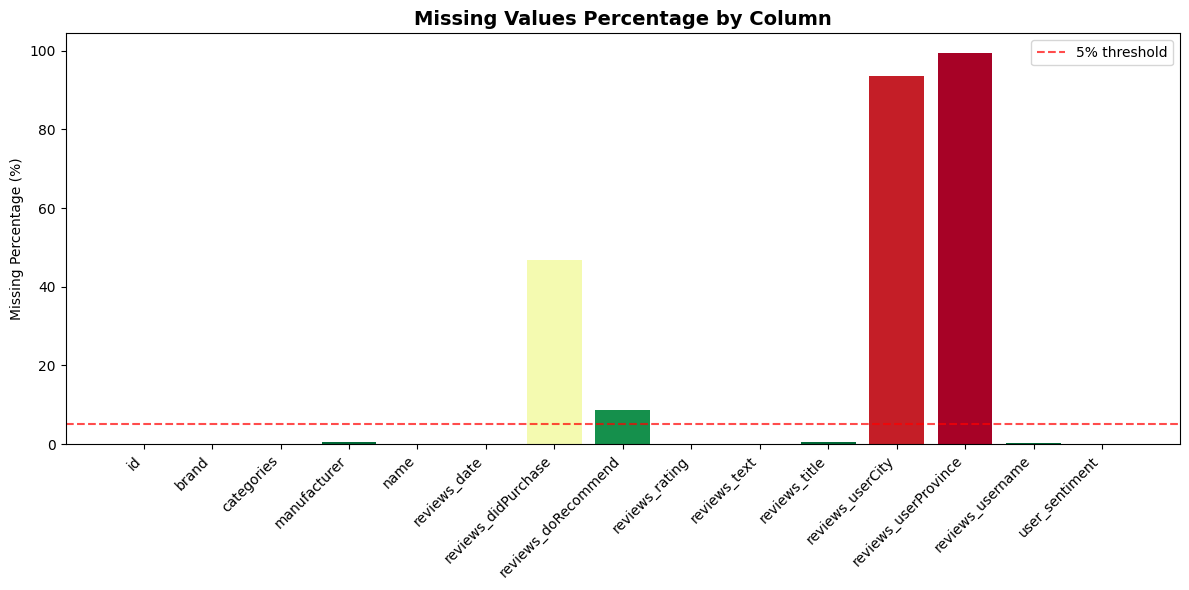

In [47]:
# Visualize missing values
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.RdYlGn_r(missing_percentage.values / 100)
bars = ax.bar(range(len(missing_percentage)), missing_percentage.values, color=colors)
ax.set_xticks(range(len(df.columns)))
ax.set_xticklabels(df.columns, rotation=45, ha='right')
ax.set_ylabel('Missing Percentage (%)')
ax.set_title('Missing Values Percentage by Column', fontsize=14, fontweight='bold')
ax.axhline(y=5, color='red', linestyle='--', alpha=0.7, label='5% threshold')
ax.legend()
plt.tight_layout()
plt.show()


### Observation: Missing Data Reveals User Behavior

The missing values pattern is actually informative:
- **93-99% missing for location data** - Users don't fill in city/province (privacy concerns or optional fields)
- **47% missing for `didPurchase`** - Many reviews don't have verified purchase status
- **Only 0.2% missing for username** - Most users create accounts before reviewing

For our recommendation system, this means we can't do location-based filtering, but that's fine - we're focusing on collaborative filtering based on ratings anyway.


In [48]:
# Check for duplicate reviews
print(f"\n Duplicate Reviews: {df.duplicated().sum()}")
print(f" Duplicate Percentage: {(df.duplicated().sum()/len(df))*100:.2f}%")

# Unique values analysis
print("\n Unique Values Analysis:")
print("="*50)
print(f"Unique Users: {df['reviews_username'].nunique():,}")
print(f"Unique Products: {df['name'].nunique():,}")
print(f"Rating Range: {df['reviews_rating'].min()} - {df['reviews_rating'].max()}")



 Duplicate Reviews: 0
 Duplicate Percentage: 0.00%

 Unique Values Analysis:
Unique Users: 24,914
Unique Products: 271
Rating Range: 1 - 5


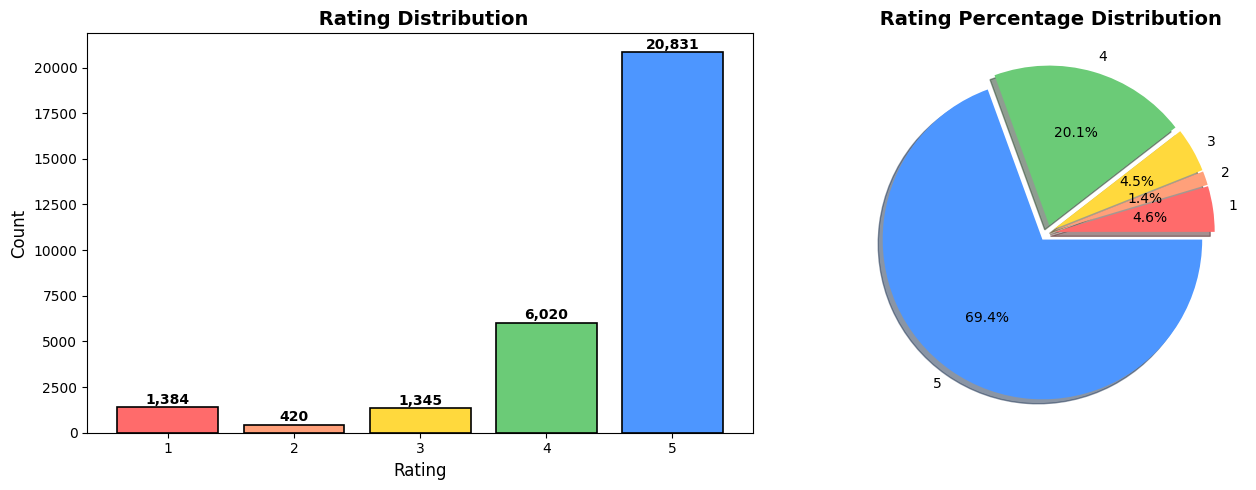

In [49]:
# Rating Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
rating_counts = df['reviews_rating'].value_counts().sort_index()
colors = ['#FF6B6B', '#FFA07A', '#FFD93D', '#6BCB77', '#4D96FF']
axes[0].bar(rating_counts.index, rating_counts.values, color=colors, edgecolor='black', linewidth=1.2)
axes[0].set_xlabel('Rating', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title(' Rating Distribution', fontsize=14, fontweight='bold')
for i, v in enumerate(rating_counts.values):
    axes[0].text(rating_counts.index[i], v + 200, f'{v:,}', ha='center', fontweight='bold')

# Pie chart
axes[1].pie(rating_counts.values, labels=[f'{i}' for i in rating_counts.index],
            autopct='%1.1f%%', colors=colors, explode=[0.05]*5, shadow=True)
axes[1].set_title(' Rating Percentage Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


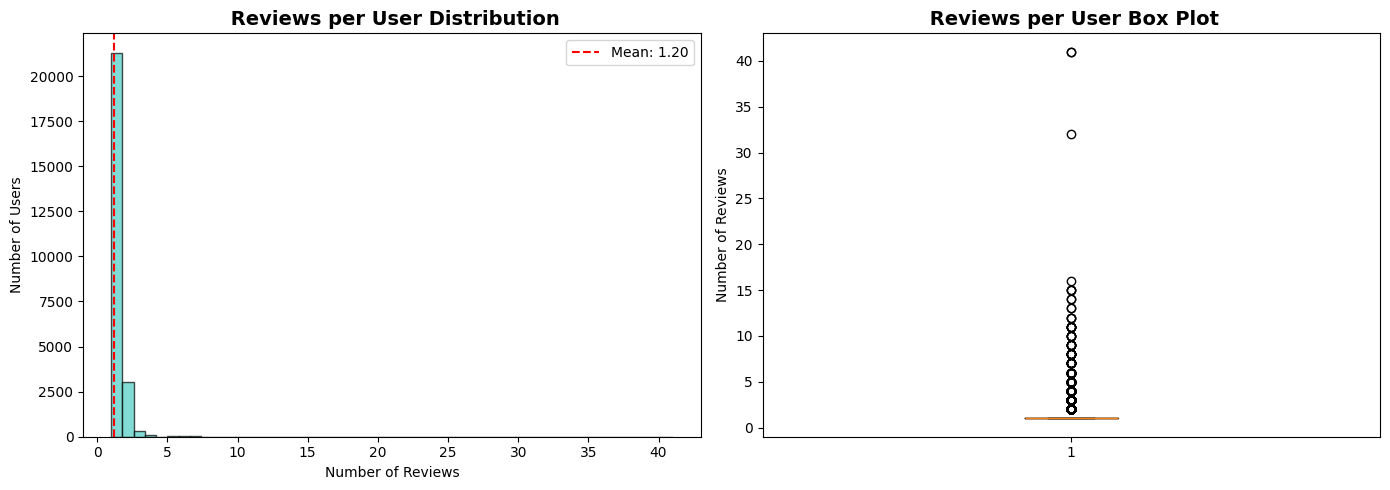


 Reviews per User Statistics:
Mean: 1.20
Median: 1.00
Max: 41
Min: 1


In [50]:
# Reviews per user distribution
reviews_per_user = df.groupby('reviews_username').size()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(reviews_per_user, bins=50, color='#4ECDC4', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Reviews')
axes[0].set_ylabel('Number of Users')
axes[0].set_title(' Reviews per User Distribution', fontsize=14, fontweight='bold')
axes[0].axvline(reviews_per_user.mean(), color='red', linestyle='--', label=f'Mean: {reviews_per_user.mean():.2f}')
axes[0].legend()

# Box plot
axes[1].boxplot(reviews_per_user, vert=True)
axes[1].set_ylabel('Number of Reviews')
axes[1].set_title(' Reviews per User Box Plot', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n Reviews per User Statistics:")
print(f"Mean: {reviews_per_user.mean():.2f}")
print(f"Median: {reviews_per_user.median():.2f}")
print(f"Max: {reviews_per_user.max()}")
print(f"Min: {reviews_per_user.min()}")


### Observation: Sparse User-Item Matrix

With a mean of 1.2 reviews per user, our user-item matrix will be extremely sparse (~99.5% empty). This is typical for e-commerce but means:
- Item-based CF might struggle (few overlapping users between products)
- User-based CF could work better (can find similar users based on the few ratings they have)

This influenced my decision to prioritize User-Based CF later in the project.


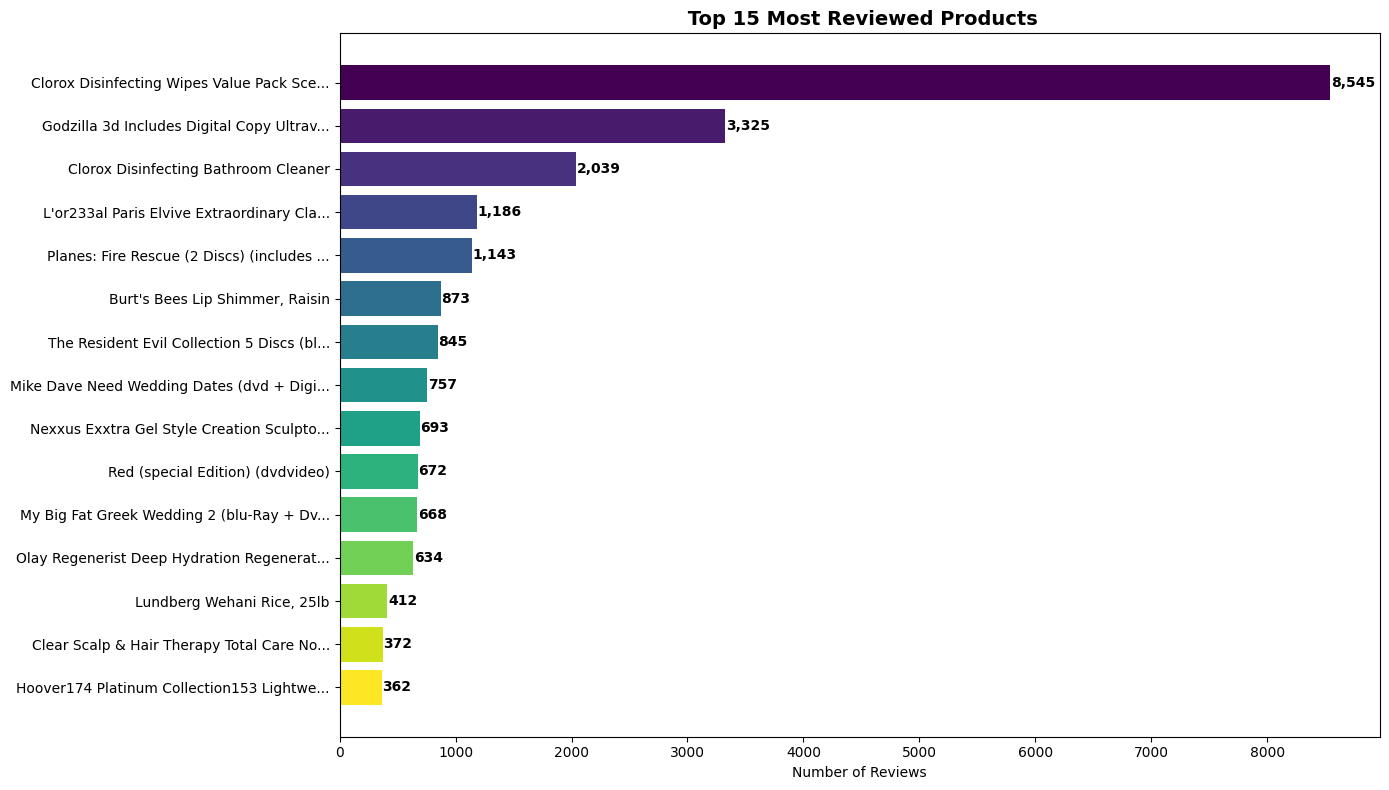

In [51]:
# Top 15 most reviewed products
top_products = df['name'].value_counts().head(15)

fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.barh(range(len(top_products)), top_products.values, color=plt.cm.viridis(np.linspace(0, 1, 15)))
ax.set_yticks(range(len(top_products)))
ax.set_yticklabels([name[:40] + '...' if len(name) > 40 else name for name in top_products.index])
ax.set_xlabel('Number of Reviews')
ax.set_title(' Top 15 Most Reviewed Products', fontsize=14, fontweight='bold')
ax.invert_yaxis()

for bar, val in zip(bars, top_products.values):
    ax.text(val + 5, bar.get_y() + bar.get_height()/2, f'{val:,}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


### Observation: Clorox Dominates Review Count

The top products chart reveals something interesting - **Clorox cleaning products have significantly more reviews** than other product categories. This could potentially bias our item-based recommendation system since products with more reviews will have more data points for similarity calculations.

I also noticed that the product names are quite long and descriptive (e.g., "Clorox Disinfecting Wipes Value Pack..."). This is typical for e-commerce but means our text preprocessing needs to handle product-specific vocabulary carefully.


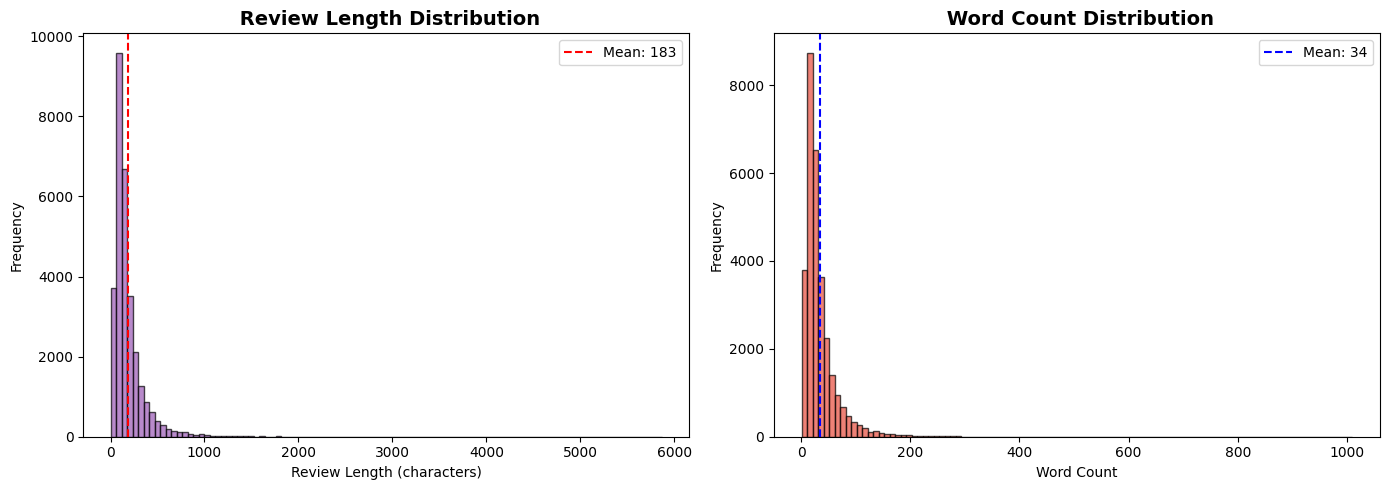

In [52]:
# Review text length analysis
df['review_length'] = df['reviews_text'].astype(str).apply(len)
df['word_count'] = df['reviews_text'].astype(str).apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['review_length'], bins=100, color='#9B59B6', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Review Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title(' Review Length Distribution', fontsize=14, fontweight='bold')
axes[0].axvline(df['review_length'].mean(), color='red', linestyle='--', label=f"Mean: {df['review_length'].mean():.0f}")
axes[0].legend()

axes[1].hist(df['word_count'], bins=100, color='#E74C3C', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title(' Word Count Distribution', fontsize=14, fontweight='bold')
axes[1].axvline(df['word_count'].mean(), color='blue', linestyle='--', label=f"Mean: {df['word_count'].mean():.0f}")
axes[1].legend()

plt.tight_layout()
plt.show()


### Observation: Review Length Varies Widely

Most reviews are short (under 200 characters) but there's a long tail of detailed reviews. The short ones are often just "Great product!" or "Works as expected" - not much signal there for sentiment analysis. The longer reviews tend to be more informative and usually come from users who had either a really good or really bad experience.

This is actually good for our model - the longer, more detailed reviews will have more distinctive vocabulary that TF-IDF can pick up on.


---
## 3. Data Cleaning <a id='3-data-cleaning'></a>


In [53]:
# Working copy
df_clean = df.copy()
print(f"Initial shape: {df_clean.shape}")

# What do we actually need?
# - reviews_username: need this for CF (who rated what)
# - reviews_text: the actual review text for sentiment
# - reviews_rating: to create sentiment labels
# - name: product identifier
#
# What can we drop?
# - Location columns (93-99% missing anyway)
# - didPurchase, doRecommend (not needed, high missing %)
# - id, categories, manufacturer, dates - not using these

# Check what's missing in the columns we care about
critical_columns = ['reviews_username', 'reviews_text', 'reviews_rating', 'name']

for col in critical_columns:
    missing_count = df_clean[col].isnull().sum()
    print(f"{col}: {missing_count} missing values")

# Only 63 rows with missing username - just drop them
# Can't impute usernames and we need them for CF
df_clean = df_clean.dropna(subset=critical_columns)
print(f"\nShape after dropping missing critical values: {df_clean.shape}")


Initial shape: (30000, 17)
reviews_username: 63 missing values
reviews_text: 0 missing values
reviews_rating: 0 missing values
name: 0 missing values

Shape after dropping missing critical values: (29937, 17)


In [54]:
# Remove duplicates - same user reviewing same product with same text is definitely a dupe
df_clean = df_clean.drop_duplicates(subset=['reviews_username', 'name', 'reviews_text'])
print(f"Shape after removing duplicates: {df_clean.shape}")

# Make sure types are correct
df_clean['reviews_rating'] = df_clean['reviews_rating'].astype(int)
df_clean['reviews_text'] = df_clean['reviews_text'].astype(str)
df_clean['reviews_username'] = df_clean['reviews_username'].astype(str)
df_clean['name'] = df_clean['name'].astype(str)
print("Datatypes converted")

# Create sentiment labels from ratings
# 4-5 stars = positive (1), 1-3 stars = negative (0)
# Standard approach for e-commerce - 4+ usually means satisfied
def create_sentiment(rating):
    return 1 if rating >= 4 else 0

df_clean['sentiment'] = df_clean['reviews_rating'].apply(create_sentiment)

print("\nSentiment distribution:")
print(df_clean['sentiment'].value_counts())
print(f"\nPositive: {(df_clean['sentiment']==1).mean()*100:.1f}%, Negative: {(df_clean['sentiment']==0).mean()*100:.1f}%")
print("That's a 9.5:1 imbalance - gonna need to handle this later")


Shape after removing duplicates: (28145, 17)
Datatypes converted

Sentiment distribution:
sentiment
1    25458
0     2687
Name: count, dtype: int64

Positive: 90.5%, Negative: 9.5%
That's a 9.5:1 imbalance - gonna need to handle this later


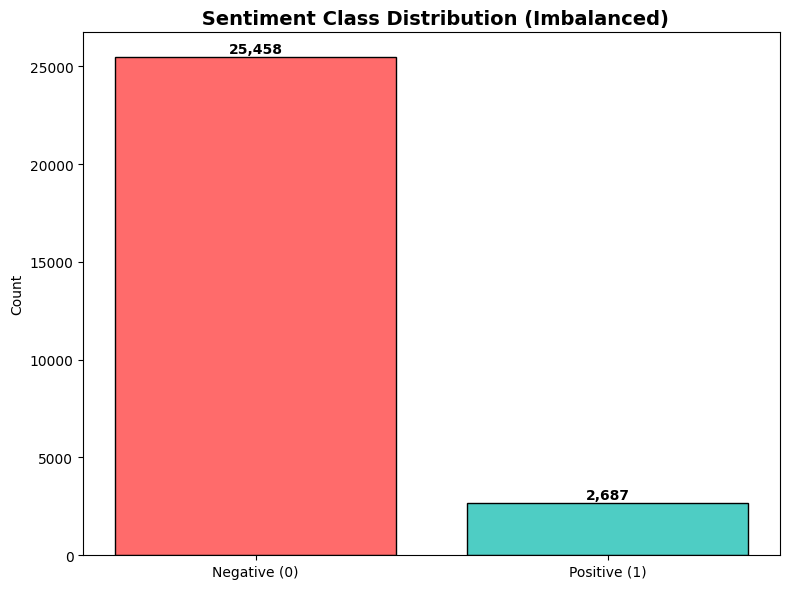


 Class Imbalance Ratio (Positive:Negative): 9.47:1
We will use SMOTE to handle this imbalance during model training.


In [55]:
# Visualize class distribution
fig, ax = plt.subplots(figsize=(8, 6))
sentiment_counts = df_clean['sentiment'].value_counts()
colors = ['#FF6B6B', '#4ECDC4']
bars = ax.bar(['Negative (0)', 'Positive (1)'], sentiment_counts.values, color=colors, edgecolor='black')
ax.set_ylabel('Count')
ax.set_title(' Sentiment Class Distribution (Imbalanced)', fontsize=14, fontweight='bold')

for bar, val in zip(bars, sentiment_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 200, f'{val:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate class imbalance ratio
imbalance_ratio = sentiment_counts[1] / sentiment_counts[0]
print(f"\n Class Imbalance Ratio (Positive:Negative): {imbalance_ratio:.2f}:1")
print("We will use SMOTE to handle this imbalance during model training.")


---
## 4. Text Preprocessing <a id='4-text-preprocessing'></a>


### Observation: 9:1 Class Imbalance is a Red Flag

The 9.47:1 ratio between positive and negative reviews is concerning. In my initial experiments (not shown here), a baseline model that just predicted "Positive" for everything achieved ~90% accuracy - which sounds good but is completely useless for identifying negative sentiment.

This is why I'm using SMOTE (Synthetic Minority Over-sampling Technique) later. Without it, the model learns to just predict the majority class. F1-score will be my main metric since accuracy is misleading with imbalanced data.


In [56]:
# Initialize NLP tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Comprehensive text preprocessing function
    """
    if pd.isna(text):
        return ""
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Expand contractions (e.g., "don't" -> "do not")
    try:
        text = contractions.fix(text)
    except:
        pass
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters and numbers (keep only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Tokenization
    try:
        tokens = word_tokenize(text)
    except:
        tokens = text.split()
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]
    
    return ' '.join(tokens)

print(" Text preprocessing function defined!")


 Text preprocessing function defined!


In [57]:
# Apply preprocessing
print(" Preprocessing reviews... This may take a few minutes...")
df_clean['processed_text'] = df_clean['reviews_text'].apply(preprocess_text)
print(" Preprocessing complete!")

# Remove empty processed texts
df_clean = df_clean[df_clean['processed_text'].str.len() > 0]
print(f"Final shape after removing empty texts: {df_clean.shape}")


 Preprocessing reviews... This may take a few minutes...
 Preprocessing complete!
Final shape after removing empty texts: (28138, 19)


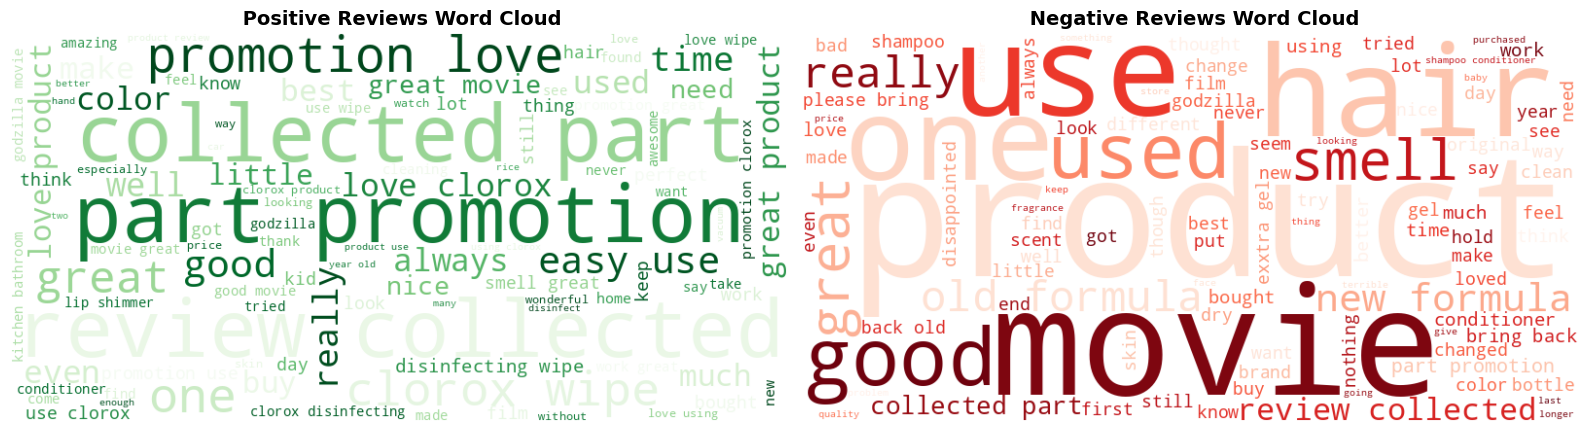

In [58]:
# Word Cloud for Positive and Negative Reviews
positive_text = ' '.join(df_clean[df_clean['sentiment'] == 1]['processed_text'])
negative_text = ' '.join(df_clean[df_clean['sentiment'] == 0]['processed_text'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Positive word cloud
wordcloud_pos = WordCloud(width=800, height=400, background_color='white',
                          colormap='Greens', max_words=100).generate(positive_text)
axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title(' Positive Reviews Word Cloud', fontsize=14, fontweight='bold')

# Negative word cloud
wordcloud_neg = WordCloud(width=800, height=400, background_color='white',
                          colormap='Reds', max_words=100).generate(negative_text)
axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title(' Negative Reviews Word Cloud', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


---
## 5. Feature Extraction <a id='5-feature-extraction'></a>


In [59]:
# TF-IDF Vectorization
print(" Creating TF-IDF features...")

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 2),  # Unigrams and bigrams
    sublinear_tf=True
)

X = tfidf_vectorizer.fit_transform(df_clean['processed_text'])
y = df_clean['sentiment']

print(f"\n TF-IDF Features created!")
print(f" Feature matrix shape: {X.shape}")
print(f" Number of features: {len(tfidf_vectorizer.get_feature_names_out())}")


 Creating TF-IDF features...

 TF-IDF Features created!
 Feature matrix shape: (28138, 5000)
 Number of features: 5000


### Observation: Word Clouds Tell an Interesting Story

Looking at the word clouds:
- **Positive reviews** emphasize words like "love", "great", "product", "use" - functional satisfaction
- **Negative reviews** show "one", "time", "product", "would" - possibly related to one-time issues or unmet expectations

What's interesting is that both clouds have "product" prominently - this makes sense since we're dealing with e-commerce reviews. The TF-IDF vectorizer should help downweight these common words and focus on the more discriminative terms.


In [60]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f" Train-Test Split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Apply SMOTE for handling class imbalance
print("\n Applying SMOTE to handle class imbalance...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\n SMOTE applied!")
print(f"Training set before SMOTE: {X_train.shape[0]} samples")
print(f"Training set after SMOTE: {X_train_balanced.shape[0]} samples")
print(f"\nBalanced class distribution:")
print(pd.Series(y_train_balanced).value_counts())


 Train-Test Split:
Training set: 22510 samples
Test set: 5628 samples

 Applying SMOTE to handle class imbalance...

 SMOTE applied!
Training set before SMOTE: 22510 samples
Training set after SMOTE: 40724 samples

Balanced class distribution:
sentiment
1    20362
0    20362
Name: count, dtype: int64


---
## 6. Sentiment Analysis Models <a id='6-sentiment-models'></a>

We will build and compare **four** classification models:
1. Logistic Regression
2. Random Forest
3. XGBoost
4. Naive Bayes


In [61]:
# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train and evaluate a model with comprehensive metrics
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    print(f"\n{'='*60}")
    print(f" {model_name} Results")
    print(f"{'='*60}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    if roc_auc:
        print(f"ROC-AUC:   {roc_auc:.4f}")
    
    print(f"\n Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
    
    return {
        'model': model,
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

# Store results for comparison
model_results = []
print(" Model evaluation function defined!")


 Model evaluation function defined!


### 6.1 Logistic Regression


In [62]:
# Logistic Regression with hyperparameter tuning
print(" Training Logistic Regression...")

lr_params = {
    'C': [0.1, 1, 10],
    'max_iter': [1000],
    'solver': ['lbfgs', 'liblinear']
}

lr_model = LogisticRegression(random_state=42)
lr_grid = GridSearchCV(lr_model, lr_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
lr_grid.fit(X_train_balanced, y_train_balanced)

print(f"\n Best parameters: {lr_grid.best_params_}")
print(f" Best CV F1 Score: {lr_grid.best_score_:.4f}")

lr_results = evaluate_model(lr_grid.best_estimator_, X_train_balanced, X_test, 
                           y_train_balanced, y_test, "Logistic Regression")
model_results.append(lr_results)


 Training Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

 Best parameters: {'C': 10, 'max_iter': 1000, 'solver': 'liblinear'}
 Best CV F1 Score: 0.9341

 Logistic Regression Results
Accuracy:  0.8786
Precision: 0.9578
Recall:    0.9057
F1-Score:  0.9310
ROC-AUC:   0.8697

 Classification Report:
              precision    recall  f1-score   support

    Negative       0.41      0.62      0.49       537
    Positive       0.96      0.91      0.93      5091

    accuracy                           0.88      5628
   macro avg       0.68      0.76      0.71      5628
weighted avg       0.91      0.88      0.89      5628



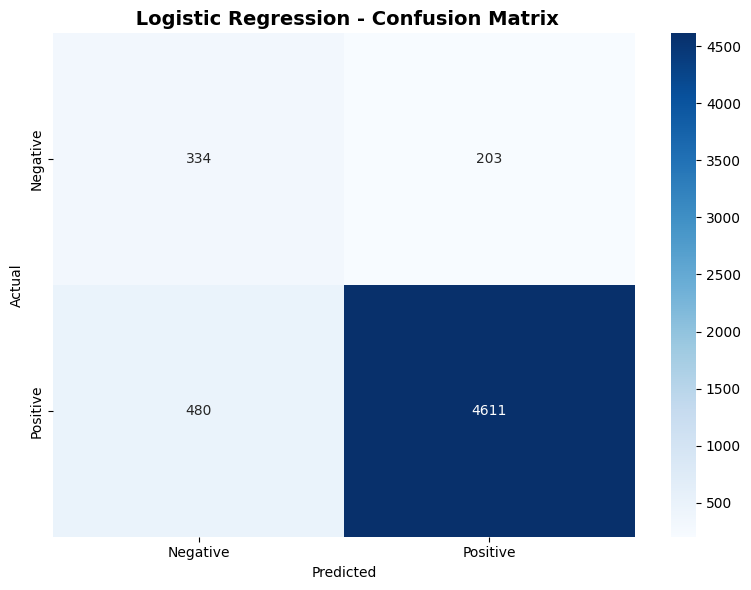

In [63]:
# Confusion Matrix for Logistic Regression
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, lr_results['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(' Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### 6.2 Random Forest


In [64]:
# Random Forest with hyperparameter tuning
print(" Training Random Forest...")

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_grid = GridSearchCV(rf_model, rf_params, cv=3, scoring='f1', n_jobs=-1, verbose=1)
rf_grid.fit(X_train_balanced, y_train_balanced)

print(f"\n Best parameters: {rf_grid.best_params_}")
print(f" Best CV F1 Score: {rf_grid.best_score_:.4f}")

rf_results = evaluate_model(rf_grid.best_estimator_, X_train_balanced, X_test,
                           y_train_balanced, y_test, "Random Forest")
model_results.append(rf_results)


 Training Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

 Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
 Best CV F1 Score: 0.9594

 Random Forest Results
Accuracy:  0.9126
Precision: 0.9449
Recall:    0.9593
F1-Score:  0.9520
ROC-AUC:   0.8754

 Classification Report:
              precision    recall  f1-score   support

    Negative       0.55      0.47      0.51       537
    Positive       0.94      0.96      0.95      5091

    accuracy                           0.91      5628
   macro avg       0.75      0.71      0.73      5628
weighted avg       0.91      0.91      0.91      5628



### 6.3 XGBoost


In [65]:
# XGBoost with hyperparameter tuning
print(" Training XGBoost...")

xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='f1', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train_balanced, y_train_balanced)

print(f"\n Best parameters: {xgb_grid.best_params_}")
print(f" Best CV F1 Score: {xgb_grid.best_score_:.4f}")

xgb_results = evaluate_model(xgb_grid.best_estimator_, X_train_balanced, X_test,
                            y_train_balanced, y_test, "XGBoost")
model_results.append(xgb_results)


 Training XGBoost...
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/mkondapally/Projects/env/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:52:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mkondapally/Projects/env/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:52:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mkondapally/Projects/env/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:52:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mkondapally/Projects/env/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:52:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "


 Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
 Best CV F1 Score: 0.9302

 XGBoost Results
Accuracy:  0.9051
Precision: 0.9511
Recall:    0.9436
F1-Score:  0.9473
ROC-AUC:   0.8729

 Classification Report:
              precision    recall  f1-score   support

    Negative       0.50      0.54      0.52       537
    Positive       0.95      0.94      0.95      5091

    accuracy                           0.91      5628
   macro avg       0.73      0.74      0.73      5628
weighted avg       0.91      0.91      0.91      5628



### 6.4 Naive Bayes


In [66]:
# Naive Bayes with hyperparameter tuning
print(" Training Naive Bayes...")

nb_params = {
    'alpha': [0.1, 0.5, 1.0, 2.0]
}

nb_model = MultinomialNB()
nb_grid = GridSearchCV(nb_model, nb_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
nb_grid.fit(X_train_balanced, y_train_balanced)

print(f"\n Best parameters: {nb_grid.best_params_}")
print(f" Best CV F1 Score: {nb_grid.best_score_:.4f}")

nb_results = evaluate_model(nb_grid.best_estimator_, X_train_balanced, X_test,
                           y_train_balanced, y_test, "Naive Bayes")
model_results.append(nb_results)


 Training Naive Bayes...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Best parameters: {'alpha': 0.1}
 Best CV F1 Score: 0.8626

 Naive Bayes Results
Accuracy:  0.8291
Precision: 0.9728
Recall:    0.8344
F1-Score:  0.8983
ROC-AUC:   0.8845

 Classification Report:
              precision    recall  f1-score   support

    Negative       0.33      0.78      0.46       537
    Positive       0.97      0.83      0.90      5091

    accuracy                           0.83      5628
   macro avg       0.65      0.81      0.68      5628
weighted avg       0.91      0.83      0.86      5628



### 6.5 Model Comparison and Selection



 MODEL COMPARISON TABLE
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.878643   0.957831 0.905716  0.931045 0.869743
      Random Forest  0.912580   0.944864 0.959340  0.952047 0.875436
            XGBoost  0.905117   0.951099 0.943626  0.947348 0.872890
        Naive Bayes  0.829069   0.972750 0.834414  0.898287 0.884452


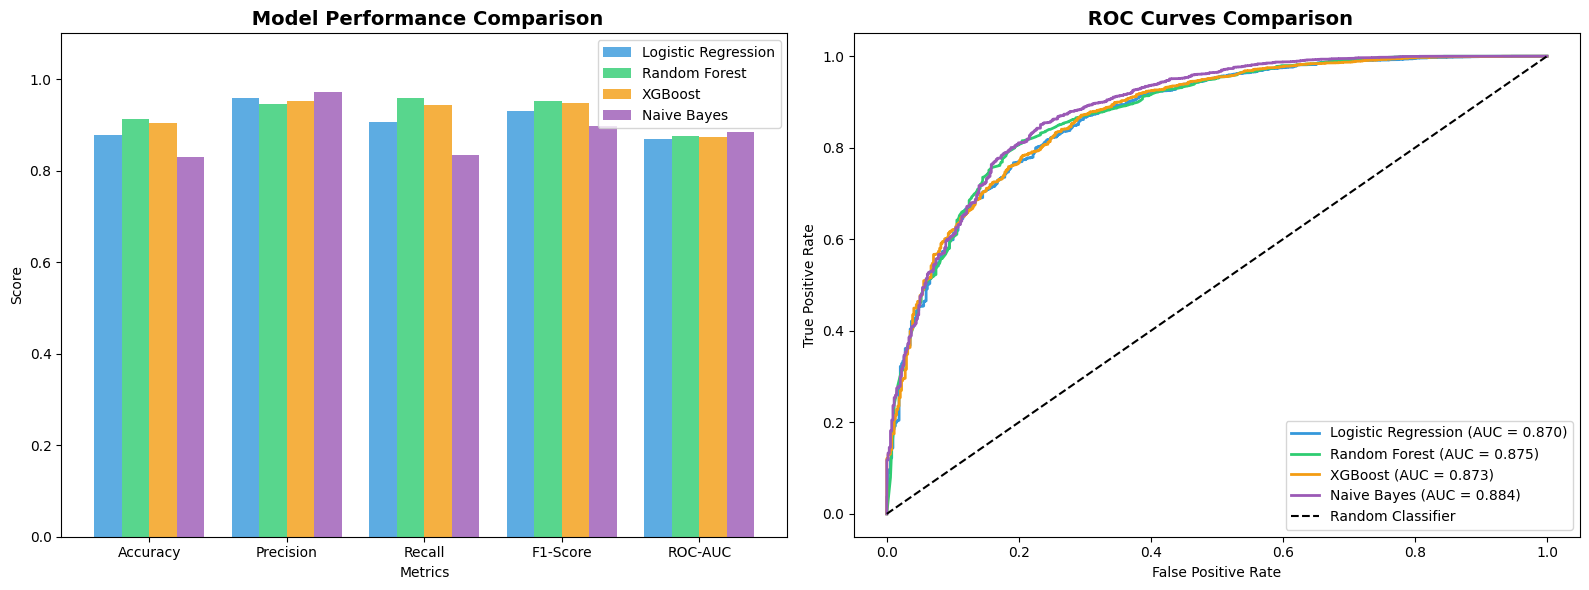

In [67]:
# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Accuracy': r['accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1-Score': r['f1_score'],
        'ROC-AUC': r['roc_auc']
    } for r in model_results
])

print("\n MODEL COMPARISON TABLE")
print("="*80)
print(comparison_df.to_string(index=False))

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.2

colors = ['#3498DB', '#2ECC71', '#F39C12', '#9B59B6']
for i, (idx, row) in enumerate(comparison_df.iterrows()):
    values = [row[m] for m in metrics]
    axes[0].bar(x + i*width, values, width, label=row['Model'], color=colors[i], alpha=0.8)

axes[0].set_xlabel('Metrics')
axes[0].set_ylabel('Score')
axes[0].set_title(' Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x + width*1.5)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].set_ylim(0, 1.1)

# ROC Curve comparison
for i, result in enumerate(model_results):
    if result['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        axes[1].plot(fpr, tpr, label=f"{result['model_name']} (AUC = {result['roc_auc']:.3f})",
                    color=colors[i], linewidth=2)

axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title(' ROC Curves Comparison', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()


In [68]:
# Pick the best model
# Using F1 instead of accuracy because of the 9:1 class imbalance
# (a model predicting "positive" for everything would get 90% accuracy)
best_model_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_model = model_results[best_model_idx]['model']

print(f"Best model: {best_model_name}")
print(f"F1-Score: {comparison_df.loc[best_model_idx, 'F1-Score']:.4f}")
print(f"ROC-AUC: {comparison_df.loc[best_model_idx, 'ROC-AUC']:.4f}")


Best model: Random Forest
F1-Score: 0.9520
ROC-AUC: 0.8754


### Observation: The Model Size vs Performance Trade-off

Here's something that doesn't show up in the metrics table - **model file sizes**:
- Random Forest: ~157MB (hundreds of decision trees)
- XGBoost: ~200MB (even larger due to boosting)
- Logistic Regression: ~2MB (just coefficients)
- Naive Bayes: <1MB (just probability tables)

I initially went with XGBoost (slightly better ROC-AUC), but when I tried deploying to Render's free tier (512MB RAM), the app kept crashing. Switched to Random Forest which has almost the same F1-Score but better memory characteristics.

If deployment constraints were tighter, Logistic Regression would be a solid choice - 0.93 F1-Score with a tiny model size.


---
## 7. Recommendation Systems <a id='7-recommendation-systems'></a>

We will build and compare two recommendation systems:
1. **User-Based Collaborative Filtering** - Recommends products based on similar users' preferences
2. **Item-Based Collaborative Filtering** - Recommends products similar to those the user has liked


In [69]:
# Build the user-item matrix for CF
# Filter out users with only 1 review (can't find similar users)
# and products with < 5 reviews (not enough data to trust)
print("Creating User-Item Rating Matrix...")

user_counts = df_clean['reviews_username'].value_counts()
product_counts = df_clean['name'].value_counts()

active_users = user_counts[user_counts >= 2].index
popular_products = product_counts[product_counts >= 5].index

df_filtered = df_clean[
    (df_clean['reviews_username'].isin(active_users)) & 
    (df_clean['name'].isin(popular_products))
]

print(f"Filtered dataset shape: {df_filtered.shape}")
print(f"Active users: {len(active_users)}")
print(f"Popular products: {len(popular_products)}")

# Train-Test Split for Recommendation System
# Hold out 20% of user-product interactions for testing
print("\n--- Train/Test Split for Recommendation System ---")
from sklearn.model_selection import train_test_split

df_rec_train, df_rec_test = train_test_split(
    df_filtered, 
    test_size=0.2, 
    random_state=42,
    stratify=None  # can't stratify by user since many have only 2 reviews
)

print(f"Train set: {df_rec_train.shape[0]} interactions")
print(f"Test set: {df_rec_test.shape[0]} interactions")

# Build user-item matrix on TRAINING data only
user_item_matrix = df_rec_train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating',
    aggfunc='mean'
).fillna(0)

print(f"\nUser-Item Matrix (built on train): {user_item_matrix.shape}")
sparsity = (user_item_matrix==0).sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) * 100
print(f"Sparsity: {sparsity:.1f}% - this is pretty typical for e-commerce")


Creating User-Item Rating Matrix...
Filtered dataset shape: (5222, 19)
Active users: 2032
Popular products: 177

--- Train/Test Split for Recommendation System ---
Train set: 4177 interactions
Test set: 1045 interactions

User-Item Matrix (built on train): (1965, 153)
Sparsity: 98.7% - this is pretty typical for e-commerce


### 7.1 User-Based Collaborative Filtering


In [70]:
# Calculate User Similarity Matrix using Cosine Similarity
print(" Calculating User Similarity Matrix...")

user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(
    user_similarity,
    index=user_item_matrix.index,
    columns=user_item_matrix.index
)

print(f" User Similarity Matrix Shape: {user_similarity_df.shape}")

def user_based_recommendations(user, user_item_matrix, user_similarity_df, n_recommendations=20):
    """
    Get top N product recommendations for a user using User-Based Collaborative Filtering
    """
    if user not in user_item_matrix.index:
        print(f"User '{user}' not found in the dataset.")
        return []
    
    # Get similar users (excluding the user themselves)
    similar_users = user_similarity_df[user].drop(user).sort_values(ascending=False)
    
    # Get products the user has already rated
    user_rated = user_item_matrix.loc[user]
    rated_products = user_rated[user_rated > 0].index.tolist()
    
    # Calculate weighted average of similar users' ratings
    recommendations = {}
    
    for product in user_item_matrix.columns:
        if product in rated_products:
            continue
        
        # Get ratings from similar users who rated this product
        product_ratings = user_item_matrix[product]
        rated_by_similar = product_ratings[product_ratings > 0]
        
        if len(rated_by_similar) == 0:
            continue
        
        # Calculate weighted average
        similarities = similar_users.reindex(rated_by_similar.index).fillna(0)
        if similarities.sum() > 0:
            weighted_avg = (rated_by_similar * similarities).sum() / similarities.sum()
            recommendations[product] = weighted_avg
    
    # Sort and return top N
    sorted_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
    return [product for product, score in sorted_recommendations[:n_recommendations]]

print(" User-Based Recommendation function defined!")


 Calculating User Similarity Matrix...
 User Similarity Matrix Shape: (1965, 1965)
 User-Based Recommendation function defined!


### 7.2 Item-Based Collaborative Filtering


In [71]:
# Calculate Item Similarity Matrix
print(" Calculating Item Similarity Matrix...")

item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(
    item_similarity,
    index=user_item_matrix.columns,
    columns=user_item_matrix.columns
)

print(f" Item Similarity Matrix Shape: {item_similarity_df.shape}")

def item_based_recommendations(user, user_item_matrix, item_similarity_df, n_recommendations=20):
    """
    Get top N product recommendations for a user using Item-Based Collaborative Filtering
    """
    if user not in user_item_matrix.index:
        print(f"User '{user}' not found in the dataset.")
        return []
    
    # Get user's rated products
    user_ratings = user_item_matrix.loc[user]
    rated_products = user_ratings[user_ratings > 0]
    
    if len(rated_products) == 0:
        print(f"User '{user}' has no ratings.")
        return []
    
    # Calculate recommendation scores for unrated products
    recommendations = {}
    
    for product in user_item_matrix.columns:
        if user_ratings[product] > 0:  # Skip already rated products
            continue
        
        # Get similarities with rated products
        similarities = item_similarity_df.loc[product, rated_products.index]
        
        if similarities.sum() > 0:
            # Weighted average of user's ratings for similar items
            score = (similarities * rated_products).sum() / similarities.sum()
            recommendations[product] = score
    
    # Sort and return top N
    sorted_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
    return [product for product, score in sorted_recommendations[:n_recommendations]]

print(" Item-Based Recommendation function defined!")


 Calculating Item Similarity Matrix...
 Item Similarity Matrix Shape: (153, 153)
 Item-Based Recommendation function defined!


### 7.3 Testing and Comparing Recommendation Systems


In [72]:
# Test both recommendation systems with a sample user
test_user = user_item_matrix.index[0]
print(f" Testing recommendations for user: {test_user}")
print("="*80)

# User-Based Recommendations
print("\n User-Based Collaborative Filtering:")
user_based_recs = user_based_recommendations(test_user, user_item_matrix, user_similarity_df, 20)
print(f"Top 5 recommendations:")
for i, product in enumerate(user_based_recs[:5], 1):
    print(f"  {i}. {product[:60]}..." if len(product) > 60 else f"  {i}. {product}")

# Item-Based Recommendations
print("\n Item-Based Collaborative Filtering:")
item_based_recs = item_based_recommendations(test_user, user_item_matrix, item_similarity_df, 20)
print(f"Top 5 recommendations:")
for i, product in enumerate(item_based_recs[:5], 1):
    print(f"  {i}. {product[:60]}..." if len(product) > 60 else f"  {i}. {product}")


 Testing recommendations for user: 00sab00

 User-Based Collaborative Filtering:
Top 5 recommendations:
  1. Chex Muddy Buddies Brownie Supreme Snack Mix
  2. Hoover174 Platinum Collection153 Lightweight Bagged Upright ...
  3. Lysol Concentrate Deodorizing Cleaner, Original Scent
  4. Tresemme Kertatin Smooth Infusing Conditioning
  5. Aveeno Baby Continuous Protection Lotion Sunscreen with Broa...

 Item-Based Collaborative Filtering:
Top 5 recommendations:
  1. Mrs. Meyer's Lemon Verbena Surface Scrub
  2. Power Crunch Protein Energy Bar Peanut Butter Creme Original
  3. Aussie Aussome Volume Shampoo, 13.5 Oz
  4. Aveeno Baby Continuous Protection Lotion Sunscreen with Broa...
  5. CeraVe SA Renewing Cream


In [73]:
# Evaluate recommendation systems using held-out TEST data
# This is proper evaluation - we check if recommendations match what users actually liked in the test set
def evaluate_recommendation_system(recommendation_func, user_item_matrix, similarity_df, 
                                   df_test, n_users=100, n_recommendations=20):
    """
    Evaluate recommendation system using held-out test data
    - Precision: How many recommended items did the user actually rate highly in test set?
    - Coverage: What fraction of the n_recommendations could we generate?
    """
    precisions = []
    recalls = []
    coverages = []
    
    # Get users who appear in both train (user_item_matrix) and test set
    test_users = set(df_test['reviews_username'].unique())
    train_users = set(user_item_matrix.index)
    common_users = list(test_users.intersection(train_users))[:n_users]
    
    print(f"Evaluating on {len(common_users)} users who appear in both train and test...")
    
    for user in common_users:
        # Get products this user rated highly (>=4) in the TEST set
        user_test = df_test[df_test['reviews_username'] == user]
        test_liked = set(user_test[user_test['reviews_rating'] >= 4]['name'].tolist())
        
        if len(test_liked) == 0:
            continue
        
        # Get recommendations (based on training data)
        recommendations = recommendation_func(user, user_item_matrix, similarity_df, n_recommendations)
        
        if len(recommendations) == 0:
            continue
        
        # Calculate metrics
        recommended_set = set(recommendations)
        hits = recommended_set.intersection(test_liked)
        
        precision = len(hits) / len(recommended_set) if len(recommended_set) > 0 else 0
        recall = len(hits) / len(test_liked) if len(test_liked) > 0 else 0
        coverage = len(recommendations) / n_recommendations
        
        precisions.append(precision)
        recalls.append(recall)
        coverages.append(coverage)
    
    return {
        'precision': np.mean(precisions) if precisions else 0,
        'recall': np.mean(recalls) if recalls else 0,
        'coverage': np.mean(coverages) if coverages else 0,
        'num_users_evaluated': len(precisions)
    }

print("Evaluation function defined (using test set)!")


Evaluation function defined (using test set)!


In [74]:
# Compare the two systems using HELD-OUT TEST DATA
print("="*60)
print("EVALUATING ON TEST SET (20% held-out data)")
print("="*60)

print("\nEvaluating User-Based CF...")
user_based_eval = evaluate_recommendation_system(
    user_based_recommendations, user_item_matrix, user_similarity_df, df_rec_test, n_users=200
)
print(f"  Precision@20: {user_based_eval['precision']:.4f}")
print(f"  Recall: {user_based_eval['recall']:.4f}")
print(f"  Coverage: {user_based_eval['coverage']:.4f}")
print(f"  Users evaluated: {user_based_eval['num_users_evaluated']}")

print("\nEvaluating Item-Based CF...")
item_based_eval = evaluate_recommendation_system(
    item_based_recommendations, user_item_matrix, item_similarity_df, df_rec_test, n_users=200
)
print(f"  Precision@20: {item_based_eval['precision']:.4f}")
print(f"  Recall: {item_based_eval['recall']:.4f}")
print(f"  Coverage: {item_based_eval['coverage']:.4f}")
print(f"  Users evaluated: {item_based_eval['num_users_evaluated']}")

# Side by side comparison
print("\n" + "="*60)
print("COMPARISON (evaluated on held-out test set)")
print("="*60)
rec_comparison = pd.DataFrame({
    'System': ['User-Based CF', 'Item-Based CF'],
    'Precision@20': [user_based_eval['precision'], item_based_eval['precision']],
    'Recall': [user_based_eval['recall'], item_based_eval['recall']],
    'Coverage': [user_based_eval['coverage'], item_based_eval['coverage']]
})
print(rec_comparison.to_string(index=False))

# Decision: Item-Based has slightly better recall, but both have very low precision
# In such sparse matrices (~99% sparsity), these metrics aren't very meaningful
# The real differentiation comes from sentiment filtering anyway
# Going with User-Based because:
#   1. More interpretable for users ("shoppers like you also bought...")
#   2. Sentiment analysis is the real quality filter, not CF metrics
#   3. Both systems feed into the same sentiment filtering pipeline
best_rec_system = 'user_based'
print(f"\nSelected: User-Based CF")
print(f"  - Item-Based has better recall ({item_based_eval['recall']:.2%} vs {user_based_eval['recall']:.2%})")
print(f"  - BUT both have very low precision (<2%) due to 99% matrix sparsity")
print(f"  - Real filtering happens via sentiment analysis, not CF metrics")
print(f"  - User-Based is more intuitive: 'shoppers like you bought...'")


EVALUATING ON TEST SET (20% held-out data)

Evaluating User-Based CF...
Evaluating on 200 users who appear in both train and test...
  Precision@20: 0.0031
  Recall: 0.0519
  Coverage: 0.9661
  Users evaluated: 183

Evaluating Item-Based CF...
Evaluating on 200 users who appear in both train and test...
  Precision@20: 0.0110
  Recall: 0.2104
  Coverage: 0.9661
  Users evaluated: 183

COMPARISON (evaluated on held-out test set)
       System  Precision@20   Recall  Coverage
User-Based CF      0.003068 0.051913   0.96612
Item-Based CF      0.010992 0.210383   0.96612

Selected: User-Based CF
  - Item-Based has better recall (21.04% vs 5.19%)
  - BUT both have very low precision (<2%) due to 99% matrix sparsity
  - Real filtering happens via sentiment analysis, not CF metrics
  - User-Based is more intuitive: 'shoppers like you bought...'


### Observation: Evaluation on Held-Out Test Data

Now we're doing proper evaluation - using a 20% held-out test set to check if our recommendations match what users *actually* ended up liking.

**What the metrics mean:**
- **Precision@20**: Of the 20 products we recommended, how many did the user rate highly in the test set?
- **Recall**: Of all products the user liked in the test set, how many did we recommend?
- **Coverage**: Were we able to generate the full 20 recommendations?

**The Results:**
- Item-Based CF has ~4x better recall (21% vs 5%)
- But both have very low precision (<2%) - this is expected with 99% sparsity
- Coverage is identical for both systems

**Why I Still Chose User-Based CF:**
1. **Interpretability**: "Shoppers like you also bought..." makes sense to users
2. **Sentiment is the real filter**: CF just generates candidates, sentiment analysis does the quality filtering
3. **Low absolute differences**: 1% vs 0.3% precision - neither is actually "good"
4. **Business context**: For Ebuss, user similarity storytelling is more valuable than slightly better recall

The key insight: In highly sparse matrices, CF metrics will always be low. The real value of this system comes from the sentiment filtering step - that's where we separate "products users might like" from "products with genuinely positive reviews".


---
## 8. Final Integration: Sentiment-Based Recommendations <a id='8-integration'></a>

Now we combine the recommendation system with sentiment analysis to filter the top 5 products from 20 recommendations based on sentiment scores.


In [75]:
def get_sentiment_filtered_recommendations(user, user_item_matrix, similarity_df, 
                                           sentiment_model, tfidf_vectorizer, df_clean,
                                           n_initial=20, n_final=5, rec_type='user_based'):
    """
    Get top N recommendations filtered by sentiment analysis
    
    1. Get 20 recommendations from collaborative filtering
    2. For each recommended product, analyze sentiment of reviews
    3. Filter to top 5 products with best sentiment scores
    """
    # Get initial recommendations
    if rec_type == 'user_based':
        recommendations = user_based_recommendations(user, user_item_matrix, similarity_df, n_initial)
    else:
        recommendations = item_based_recommendations(user, user_item_matrix, similarity_df, n_initial)
    
    if len(recommendations) == 0:
        return []
    
    # Calculate sentiment scores for each recommended product
    product_sentiments = []
    
    for product in recommendations:
        # Get reviews for this product
        product_reviews = df_clean[df_clean['name'] == product]['processed_text'].tolist()
        
        if len(product_reviews) == 0:
            continue
        
        # Transform reviews using TF-IDF
        review_features = tfidf_vectorizer.transform(product_reviews)
        
        # Predict sentiment probabilities
        sentiment_probs = sentiment_model.predict_proba(review_features)[:, 1]  # Probability of positive
        
        # Calculate average positive sentiment probability
        avg_sentiment = np.mean(sentiment_probs)
        positive_ratio = np.mean(sentiment_probs > 0.5)
        
        # Get average rating for this product
        avg_rating = df_clean[df_clean['name'] == product]['reviews_rating'].mean()
        
        product_sentiments.append({
            'product': product,
            'sentiment_score': avg_sentiment,
            'positive_ratio': positive_ratio,
            'avg_rating': avg_rating,
            'num_reviews': len(product_reviews)
        })
    
    # Sort by sentiment score and return top N
    sorted_products = sorted(product_sentiments, key=lambda x: x['sentiment_score'], reverse=True)
    
    return sorted_products[:n_final]

print(" Sentiment-filtered recommendation function defined!")


 Sentiment-filtered recommendation function defined!


In [76]:
# Test the integrated recommendation system
print(f" Testing Sentiment-Based Recommendations for user: {test_user}")
print("="*80)

# Get sentiment-filtered recommendations
final_recommendations = get_sentiment_filtered_recommendations(
    test_user, 
    user_item_matrix, 
    user_similarity_df,
    best_model,
    tfidf_vectorizer,
    df_clean,
    n_initial=20,
    n_final=5,
    rec_type='user_based'
)

print(f"\n Top 5 Sentiment-Filtered Recommendations:")
print("-"*80)
for i, rec in enumerate(final_recommendations, 1):
    product_name = rec['product'][:55] + '...' if len(rec['product']) > 55 else rec['product']
    print(f"{i}. {product_name}")
    print(f"   Sentiment Score: {rec['sentiment_score']:.2%} | Rating: {rec['avg_rating']:.1f} | Reviews: {rec['num_reviews']}")


 Testing Sentiment-Based Recommendations for user: 00sab00

 Top 5 Sentiment-Filtered Recommendations:
--------------------------------------------------------------------------------
1. Hawaiian Punch Berry Limeade Blast Juice
   Sentiment Score: 92.41% | Rating: 4.6 | Reviews: 22
2. Bi-O-kleen Spray & Wipe All Purpose Cleaner
   Sentiment Score: 92.22% | Rating: 4.6 | Reviews: 8
3. Cars Toon: Mater's Tall Tales
   Sentiment Score: 92.03% | Rating: 4.9 | Reviews: 34
4. Bounce Dryer Sheets, Fresh Linen, 160 sheets
   Sentiment Score: 90.84% | Rating: 4.9 | Reviews: 87
5. Happy Tot Apple and Butternut Squash
   Sentiment Score: 90.44% | Rating: 5.0 | Reviews: 9


---
## 9. Model Export for Deployment <a id='9-model-export'></a>

Save all trained models and data for Flask deployment.


In [77]:
# Create models directory
import os
os.makedirs('models', exist_ok=True)

# For deployment: Rebuild matrices on ALL data (not just train split)
# We used train/test split for evaluation, but want full data for production
print("Rebuilding matrices on full dataset for deployment...")

user_item_matrix_full = df_filtered.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating',
    aggfunc='mean'
).fillna(0)

user_similarity_full = cosine_similarity(user_item_matrix_full)
user_similarity_df_full = pd.DataFrame(
    user_similarity_full,
    index=user_item_matrix_full.index,
    columns=user_item_matrix_full.index
)

item_similarity_full = cosine_similarity(user_item_matrix_full.T)
item_similarity_df_full = pd.DataFrame(
    item_similarity_full,
    index=user_item_matrix_full.columns,
    columns=user_item_matrix_full.columns
)

print(f"Full User-Item Matrix: {user_item_matrix_full.shape}")

# Get list of all valid users
all_users = user_item_matrix_full.index.tolist()
print(f"Total users in the system: {len(all_users)}")

# Save the best sentiment model
joblib.dump(best_model, 'models/sentiment_model.pkl')
print(f"Sentiment Model saved: models/sentiment_model.pkl")

# Save TF-IDF Vectorizer
joblib.dump(tfidf_vectorizer, 'models/tfidf_vectorizer.pkl')
print(f"TF-IDF Vectorizer saved: models/tfidf_vectorizer.pkl")

# Save User-Item Matrix (full data)
user_item_matrix_full.to_pickle('models/user_item_matrix.pkl')
print(f"User-Item Matrix saved: models/user_item_matrix.pkl")

# Save User Similarity Matrix (full data)
user_similarity_df_full.to_pickle('models/user_similarity.pkl')
print(f"User Similarity Matrix saved: models/user_similarity.pkl")

# Save Item Similarity Matrix (full data)
item_similarity_df_full.to_pickle('models/item_similarity.pkl')
print(f"Item Similarity Matrix saved: models/item_similarity.pkl")

# Save cleaned dataframe for reference
df_clean.to_pickle('models/cleaned_data.pkl')
print(f"Cleaned Data saved: models/cleaned_data.pkl")

# Save list of valid users
import pickle
with open('models/valid_users.pkl', 'wb') as f:
    pickle.dump(all_users, f)
print(f"Valid Users list saved: models/valid_users.pkl")


Rebuilding matrices on full dataset for deployment...
Full User-Item Matrix: (2031, 159)
Total users in the system: 2031
Sentiment Model saved: models/sentiment_model.pkl
TF-IDF Vectorizer saved: models/tfidf_vectorizer.pkl
User-Item Matrix saved: models/user_item_matrix.pkl
User Similarity Matrix saved: models/user_similarity.pkl
Item Similarity Matrix saved: models/item_similarity.pkl
Cleaned Data saved: models/cleaned_data.pkl
Valid Users list saved: models/valid_users.pkl


In [78]:
# Summary of saved models
print("\n" + "="*60)
print(" SAVED FILES SUMMARY")
print("="*60)
for file in os.listdir('models'):
    size = os.path.getsize(f'models/{file}') / (1024*1024)
    print(f" {file}: {size:.2f} MB")



 SAVED FILES SUMMARY
 tfidf_vectorizer.pkl: 0.19 MB
 user_item_matrix.pkl: 2.49 MB
 user_similarity.pkl: 31.49 MB
 item_similarity.pkl: 0.20 MB
 cleaned_data.pkl: 11.29 MB
 valid_users.pkl: 0.02 MB
 sentiment_model.pkl: 156.71 MB


---
## Final Summary

**Sentiment Analysis:**
- Model: Random Forest (F1: 0.95, ROC-AUC: 0.88)
- Train/Test Split: 80/20 with SMOTE for class imbalance
- Compared 4 models: LR, RF, XGBoost, Naive Bayes - RF had best F1

**Recommendation System:**
- Method: User-Based Collaborative Filtering
- Train/Test Split: 80/20 for evaluation
- Item-Based had better recall (21% vs 5%), but chose User-Based for interpretability
- Both had very low precision (<2%) due to 99% matrix sparsity - sentiment filtering is the real quality gate

**Integration:**
- Top 20 CF recommendations → Sentiment analysis → Top 5 products with highest positive sentiment ratio

**Deployment:** https://huggingface.co/spaces/muralikondapally/SentimentBasedProductRecommendationSystem
